In [2]:
import os
import pandas as pd

mesc_sample_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/processed/mESC"

mesc_first_sample_data_df = pd.read_parquet(os.path.join(mesc_sample_dir, "E7.5_rep1/tf_tg_data.parquet"))
print(mesc_first_sample_data_df.head())

       TF       TG  reg_potential  motif_density  mean_tf_expr  mean_tg_expr  \
0    RORB  TAMALIN            0.0       0.000000      0.013821      0.024140   
1  ZFP711    RAB39            0.0       3.737670      0.045856      0.018254   
2   TRP73    CYYR1            0.0       3.555348      0.014798      0.045602   
3    HHEX    CPED1            0.0       3.218876      0.020696      0.021737   
4    ZEB1  GM16126            0.0       0.000000      0.075492      0.008900   

   expr_product  log_reg_pot  motif_present  label  ...  \
0      0.000334          0.0              0      0  ...   
1      0.000837          0.0              1      0  ...   
2      0.000675          0.0              1      0  ...   
3      0.000450          0.0              1      0  ...   
4      0.000672          0.0              0      0  ...   

   string_database_score  string_textmining_score  string_combined_score  \
0                    NaN                      NaN                    NaN   
1           

In [3]:
print(mesc_first_sample_data_df.columns)

Index(['TF', 'TG', 'reg_potential', 'motif_density', 'mean_tf_expr',
       'mean_tg_expr', 'expr_product', 'log_reg_pot', 'motif_present', 'label',
       'in_STRING', 'in_TRRUST', 'in_KEGG', 'n_sources',
       'string_experimental_score', 'string_database_score',
       'string_textmining_score', 'string_combined_score', 'trrust_sign',
       'trrust_regulation', 'trrust_pmids', 'trrust_support_n', 'kegg_signal',
       'kegg_n_pathways', 'kegg_pathways'],
      dtype='object')


In [4]:
edge_columns = ['TF', 'TG']
score_columns = ['reg_potential', 'motif_density', 'mean_tf_expr', 'mean_tg_expr', 'expr_product', 'log_reg_pot', 'motif_present']

mesc_first_sample_data_df = mesc_first_sample_data_df[edge_columns + score_columns]
print(mesc_first_sample_data_df.columns)

Index(['TF', 'TG', 'reg_potential', 'motif_density', 'mean_tf_expr',
       'mean_tg_expr', 'expr_product', 'log_reg_pot', 'motif_present'],
      dtype='object')


In [8]:
import torch, csv
from sklearn.preprocessing import LabelEncoder
PRETRAINED_EMB_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC/MULTI/model_training_011"

def _norm_gene(n):
    return str(n).strip().upper() if n is not None else None

def load_and_align_pretrained(embeddings_pt, vocab_pt, tf_classes, tg_classes, init="zeros"):
    """
    Align pretrained TF/TG vectors to the TF/TG label spaces defined by your ChIP-seq file.
    Returns (tf_init, tg_init, D, stats_dict).
    """
    emb_bundle = torch.load(embeddings_pt, map_location="cpu")
    lab_bundle = torch.load(vocab_pt, map_location="cpu")

    tf_src = emb_bundle["tf_emb"]  # [T_src, D]
    tg_src = emb_bundle["tg_emb"]  # [G_src, D]
    D = tf_src.shape[1]

    src_tf_id2name = lab_bundle["tf_id2name"]
    src_tg_id2name = lab_bundle["tg_id2name"]
    name_to_old_tf = { _norm_gene(n): i for i, n in enumerate(src_tf_id2name) if n is not None }
    name_to_old_tg = { _norm_gene(n): i for i, n in enumerate(src_tg_id2name) if n is not None }

    def _align(classes, name_to_old, src_vecs):
        out = torch.zeros(len(classes), D)
        if init == "normal":
            torch.nn.init.normal_(out, mean=0.0, std=0.02)
        hits = 0
        for j, name in enumerate(classes):
            i = name_to_old.get(_norm_gene(name), None)
            if i is None or i < 0 or i >= src_vecs.shape[0]:
                continue
            out[j] = src_vecs[i]
            hits += 1
        return out, hits, len(classes) - hits

    tf_init, tf_hits, tf_miss = _align(tf_classes, name_to_old_tf, tf_src)
    tg_init, tg_hits, tg_miss = _align(tg_classes, name_to_old_tg, tg_src)
    stats = {"tf_hits": tf_hits, "tf_total": len(tf_classes), "tg_hits": tg_hits, "tg_total": len(tg_classes)}
    print(f"[Emb remap] TF matched {tf_hits}/{len(tf_classes)}; TG matched {tg_hits}/{len(tg_classes)}")
    return tf_init, tg_init, D, stats

def read_edges_name_indexed_tsv(path, chipseq_sep, tf_col_name, tg_col_name):
    # expects columns: tf, tg, optional weight
    rows = []
    with open(path) as f:
        r = csv.DictReader(f, delimiter=chipseq_sep)
        for row in r:
            tf = row.get(tf_col_name)
            tg = row.get(tg_col_name)
            if tf is None or tg is None:
                continue
            w = 1.0
            ws = row.get("weight", "")
            if ws not in ("", None):
                try: w = float(ws)
                except: pass
            rows.append((str(tf), str(tg), w))
    return rows

def build_encoders_from_edges(name_edges):
    tf_names = [tf for tf, _, _ in name_edges]
    tg_names = [tg for _, tg, _ in name_edges]
    tf_enc = LabelEncoder().fit(tf_names)
    tg_enc = LabelEncoder().fit(tg_names)
    return tf_enc, tg_enc

def map_edges_to_local_indices(name_edges, tf_enc, tg_enc):
    tf_ids = tf_enc.transform([tf for tf, _, _ in name_edges]).tolist()
    tg_ids = tg_enc.transform([tg for _, tg, _ in name_edges]).tolist()
    weights = [w for _, _, w in name_edges]
    edges = list(zip(tf_ids, tg_ids, weights))  # TG indices are 0..n_tg-1 (NO offset)
    return edges

def verify_vocab_alignment(tf_mat, tg_mat, tf_id2name, tg_id2name):
    n_tf_tensor = tf_mat.shape[0]
    n_tg_tensor = tg_mat.shape[0]
    n_tf_vocab  = len(tf_id2name)
    n_tg_vocab  = len(tg_id2name)

    # Hard fail if clear mismatch
    if n_tf_tensor != n_tf_vocab or n_tg_tensor != n_tg_vocab:
        raise RuntimeError(
            f"Vocab/embedding mismatch:\n"
            f"  TF: tensor rows={n_tf_tensor}, vocab len={n_tf_vocab}\n"
            f"  TG: tensor rows={n_tg_tensor}, vocab len={n_tg_vocab}\n"
            f"Make sure tf_tg_embeddings.pt and tf_tg_vocab_id2name.pt come from the SAME run."
        )

    # Optional: check for Nones in id2name (holes)
    bad_tf = [i for i, n in enumerate(tf_id2name) if n is None]
    bad_tg = [i for i, n in enumerate(tg_id2name) if n is None]
    if bad_tf or bad_tg:
        raise RuntimeError(
            f"id2name contains holes (None). "
            f"Bad TF idx: {bad_tf[:10]}...  Bad TG idx: {bad_tg[:10]}...\n"
            f"Rebuild id2name from the exact vocab used to train/save the embeddings."
        )

import numpy as np

# 1) Normalize TF/TG names the same way everywhere (matches _norm_gene)
df = mesc_first_sample_data_df.copy()
df["TF"] = df["TF"].astype(str).str.upper().str.strip()
df["TG"] = df["TG"].astype(str).str.upper().str.strip()

# 2) Choose a weight column if you want edges to carry strength; else default 1.0
#    Common choices you have available: 'reg_potential', 'log_reg_pot', or a binary like 'motif_present'.
WEIGHT_COL = "reg_potential" if "reg_potential" in df.columns else None

if WEIGHT_COL:
    df["weight"] = pd.to_numeric(df[WEIGHT_COL], errors="coerce").fillna(1.0)
else:
    df["weight"] = 1.0

# 3) Make unique (TF,TG) pairs and keep one weight per pair (first occurrence)
df_unique = df[["TF", "TG", "weight"]].dropna().drop_duplicates(subset=["TF", "TG"], keep="first")

# 4) Build the triplet list your downstream functions expect
name_edges = list(map(tuple, df_unique.itertuples(index=False, name=None)))

# 5) Proceed as before
tf_enc, tg_enc = build_encoders_from_edges(name_edges)
tf_classes = list(tf_enc.classes_)
tg_classes = list(tg_enc.classes_)

from pathlib import Path
embeddings_pt = Path(PRETRAINED_EMB_DIR) / "tf_tg_embeddings.pt"
vocab_pt = Path(PRETRAINED_EMB_DIR) / "tf_tg_vocab_id2name.pt"

tf_init, tg_init, D, _stats = load_and_align_pretrained(
    embeddings_pt, vocab_pt, tf_classes, tg_classes, init="zeros"
)

edges = map_edges_to_local_indices(name_edges, tf_enc, tg_enc)

# Optional sanity checks
n_tf, n_tg = tf_init.shape[0], tg_init.shape[0]
for k, (i, j, _) in enumerate(edges[:1000]):
    assert 0 <= i < n_tf and 0 <= j < n_tg, f"Edge {k} out of range: tf={i}, tg={j}, n_tf={n_tf}, n_tg={n_tg}"


tf_enc, tg_enc = build_encoders_from_edges(name_edges)
tf_classes = list(tf_enc.classes_)  # strings
tg_classes = list(tg_enc.classes_)

embeddings_pt = Path(PRETRAINED_EMB_DIR) / "tf_tg_embeddings.pt"
vocab_pt = Path(PRETRAINED_EMB_DIR) / "tf_tg_vocab_id2name.pt"

# --- 3) Load pretrained tensors and ALIGN by name to these classes
tf_init, tg_init, D, _stats = load_and_align_pretrained(
    embeddings_pt, vocab_pt, tf_classes, tg_classes, init="zeros"
)

# --- 4) Map edges to local integer indices (NO TG offset)
edges = map_edges_to_local_indices(name_edges, tf_enc, tg_enc)

# Optional sanity checks (prevents IndexError by construction)
n_tf, n_tg = tf_init.shape[0], tg_init.shape[0]
for k, (i, j, _) in enumerate(edges[:1000]):  # spot check a slice
    assert 0 <= i < n_tf and 0 <= j < n_tg, f"Edge {k} out of range: tf={i}, tg={j}, n_tf={n_tf}, n_tg={n_tg}"



[Emb remap] TF matched 256/256; TG matched 21/2669
[Emb remap] TF matched 256/256; TG matched 21/2669


In [9]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

def _to_numpy(t):
    try:
        import torch
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
    except ImportError:
        pass
    return np.asarray(t)

def build_feature_matrix(df, tf_enc, tg_enc, tf_init, tg_init, verbose=True):
    if verbose:
        print("\n[build_feature_matrix] Starting...")
        print(f"[build_feature_matrix] Incoming df shape: {df.shape}")
        print(f"[build_feature_matrix] Incoming columns: {list(df.columns)}")
    # Normalize TF/TG the same way as earlier code
    df = df.copy()
    df["TF"] = df["TF"].astype(str).str.upper().str.strip()
    df["TG"] = df["TG"].astype(str).str.upper().str.strip()

    # Keep only necessary columns
    cols = [
        "reg_potential", "motif_density", "mean_tf_expr", "mean_tg_expr",
        "expr_product", "log_reg_pot", "motif_present"
    ]
    present = [c for c in cols if c in df.columns]
    use_df = df[["TF", "TG"] + present].dropna(subset=["TF", "TG"]).copy()

    # Map names -> local indices used by the embedding matrices
    tf_ids = tf_enc.transform(use_df["TF"])
    tg_ids = tg_enc.transform(use_df["TG"])

    # Convert embeddings to numpy
    TF = _to_numpy(tf_init)
    TG = _to_numpy(tg_init)

    # Dot product similarity between TF/TG embeddings (shape: [N])
    dot_sim = np.einsum("nd,nd->n", TF[tf_ids], TG[tg_ids])

    # Numeric features—ensure numeric dtype
    X_extra = use_df[present].copy()
    if "motif_present" in X_extra.columns:
        # Coerce to 0/1 (handles True/False, '0'/'1', etc.)
        X_extra["motif_present"] = pd.to_numeric(X_extra["motif_present"], errors="coerce").fillna(0.0).clip(0, 1)

    X = np.column_stack([dot_sim, X_extra.to_numpy(dtype=float)])
    feature_names = ["dot_sim"] + list(X_extra.columns)
    return use_df[["TF","TG"]].reset_index(drop=True), X, feature_names

def unsupervised_svm_two_groups(df, tf_enc, tg_enc, tf_init, tg_init, kernel="rbf", C=1.0, gamma="scale", random_state=42):
    # 1) Build features
    pairs, X_raw, feature_names = build_feature_matrix(df, tf_enc, tg_enc, tf_init, tg_init)

    # 2) Impute + scale
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()
    X = scaler.fit_transform(imputer.fit_transform(X_raw))

    # 3) Unsupervised 2-component model → pseudo-labels
    gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=random_state)
    cluster = gmm.fit_predict(X)

    # 4) Orient labels so that the component with higher mean dot_sim = True(=1)
    dot_idx = feature_names.index("dot_sim")
    mean_dot_by_cluster = [X_raw[cluster==k, dot_idx].mean() if np.any(cluster==k) else -np.inf for k in (0,1)]
    true_label = int(np.argmax(mean_dot_by_cluster))   # which cluster looks more "True"
    y_pseudo = (cluster == true_label).astype(int)

    # 5) Train an SVM on the pseudo-labels
    svm = SVC(kernel=kernel, C=C, gamma=gamma, class_weight="balanced", probability=True, random_state=random_state)
    svm.fit(X, y_pseudo)

    # 6) Return everything useful
    out = pd.DataFrame({
        "TF": pairs["TF"],
        "TG": pairs["TG"],
        "pseudo_label": y_pseudo,
        "pseudo_prob_true": svm.predict_proba(X)[:, 1]
    })

    return {
        "svm": svm,
        "scaler": scaler,
        "imputer": imputer,
        "gmm": gmm,
        "feature_names": feature_names,
        "assignments": out.sort_values("pseudo_prob_true", ascending=False).reset_index(drop=True)
    }

# --- Example usage ---
result = unsupervised_svm_two_groups(
    mesc_first_sample_data_df,
    tf_enc=tf_enc,
    tg_enc=tg_enc,
    tf_init=tf_init,
    tg_init=tg_init,
    kernel="rbf",         # you can switch to "linear"
    C=1.0,
    gamma="scale",
    random_state=42
)

assignments = result["assignments"]
print(assignments.head())


       TF             TG  pseudo_label  pseudo_prob_true
0  ZFP521  2610035D17RIK             1               1.0
1  ZBTB40  2210408I21RIK             1               1.0
2  ZFP423  2610035D17RIK             1               1.0
3  ZFP521  1700034P13RIK             1               1.0
4   SALL3  2310040G24RIK             1               1.0


<Axes: >

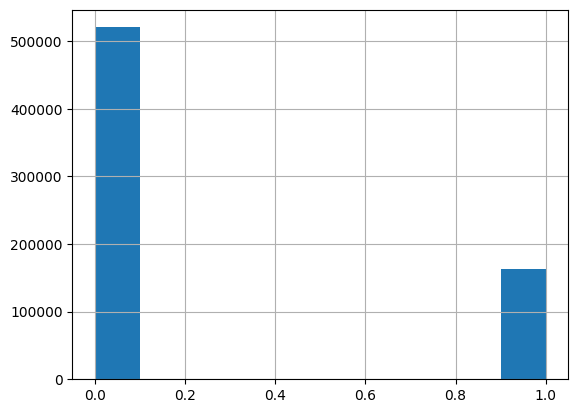

In [10]:
assignments['pseudo_prob_true'].hist()

In [12]:
inferred_df = assignments[["TF", "TG", "pseudo_prob_true"]].rename(columns={"TF":"Source", "TG":"Target", "pseudo_prob_true": "Score"})

In [13]:
inferred_df.to_csv("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/outputs/inferred_grn_svm.csv")